# Car Example for parametric MHE

In [1]:
import casadi
from casadi.tools import *
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
np.random.seed(1)

## System Definition

In [3]:
# struct with model parameters
model = dict(
    eta = 0.9,
    Ts = 0.01, # discretization time
    nx = 6,
    nw = 6,
    ny = 3,
    nv = 3,
    nu = 2,
    ntheta = 2,
    bound_w = 0.01,
    bound_vx = 0.2, # 0.5
    bound_vw = 0.01,
    prior_weighting = 1,
    # kinematic model parameters
    l_r = 0.038,
    l_f = 0.052,
    m = 0.181,
    Iz = 0.000505,
    # pacejka tire params
    Br = 8.5,
    Cr = 1.45,
    Dr = 1.0,
    Bf = 5.2,
    Cf = 1.5,
    Df = 0.65,
    # longitudinal force params
    Cm1 = 0.98028992,
    Cm2 = 0.01814131,
    Cd = 0.02750696,
    Croll = 0.08518052
)

In [4]:
def continuous_dynamics(state, action, theta, model):
    
    # extract model parameters
    l_r = model['l_r']
    l_f = model['l_f']
    Cr = model['Cr']
    Cf = model['Cf']
    Br = model['Br']
    Bf = model['Bf']
    Cm1 = model['Cm1']
    Cm2 = model['Cm2']
    Croll = model['Croll']
    Cd = model['Cd']
    m = model['m']
    Iz = model['Iz']
    
    # extract states from state vector
    x = state[0]
    y = state[1]
    psi = state[2]
    vx = state[3]
    vy = state[4]
    omega = state[5]
    
    # extract inputs from input vector
    delta = action[0]
    F_x = action[1]
    
    # parameters
    D_r = theta[0]
    D_f = theta[1]
    
    # compute slip angles and tire forces
    alpha_r = atan2((vy-omega*l_r),vx)
    alpha_f = atan2((vy+omega*l_f),vx) - delta
    F_r = -D_r*sin(Cr*atan(Br*alpha_r))
    F_f = -D_f*sin(Cf*atan(Bf*alpha_f))

    # state dynamics
    state_dot = casadi.vertcat(vx*cos(psi)-vy*sin(psi),
                    vx*sin(psi)+vy*cos(psi),
                    omega,
                    (F_x - F_f*sin(delta) + m*vy*omega)/m,
                    (F_r + F_f*cos(delta) - m*vx*omega)/m,
                    (F_f*l_f*cos(delta) - F_r*l_r)/Iz)
        
    return state_dot

In [5]:
def discrete_dynamcis(state, action, disturbance, theta, model):
    state_dot = continuous_dynamics(state, action, theta, model)
    
    Ts = model['Ts']

    state_plus = state + Ts * state_dot + disturbance
    return state_plus

In [6]:
def measurement_function(state, noise, model):
    y = state[0:3] + noise
        
    return y

In [7]:
def generate_disturbances(n_w,T,model):
    bound_w = model['bound_w']
    w = np.random.uniform(-bound_w, bound_w,(n_w,T))
    w[2,:] = w[2,:]
    return w

In [8]:
def generate_noise(n_v,T,model):
    bound_vx = model['bound_vx']
    bound_vw = model['bound_vw']
    v = np.random.uniform(-1, 1,(n_v,T))
    v[0:n_v-1,:] = v[0:n_v-1,:] * bound_vx
    v[-1,:] = v[-1,:] * bound_vw
    return v

In [9]:
def generate_inputs(T,k_start,k_end,model):
    nu = model['nu']
    
    u = np.zeros((nu,T))
    u[1,:] = 0.01 * np.ones((1,T))
    u[0,k_start:k_end] = -0.03 * np.ones((1,k_end - k_start))
    
    return u

In [10]:
def simulate_system(x0,u,w,v,theta,model,T):
    nx = model['nx']
    ny = model['ny']
    nu = model['nu']
    
    x = np.zeros((nx,T+1))
    x[:,0] = x0
    
    y = np.zeros((ny,T))
            
    state = x0
    
    for k in range(T):
        # obtain measurement
        if k == 0:
            y[:,k] = measurement_function(state, v[:,k], model)
        else:
            y[:,[k]] = measurement_function(state, v[:,k], model)
        
        # apply dynamics
        state = discrete_dynamcis(state, u[:,k], w[:,k], theta, model)
        x[:, [k+1]] = state
    return x, y

In [11]:
## simulation
nsim = 1200
x0 = np.zeros(model['nx'])
x0[3] = 4
w = generate_disturbances(model['nx'],nsim,model)
v = generate_noise(model['ny'],nsim,model)
theta = vertcat(model['Dr'],model['Df'])

k_start = 300 # start of right turn
k_end = 600 # end of right turn
u = generate_inputs(nsim,k_start,k_end,model)

x, y = simulate_system(x0,u,w,v,theta,model,nsim)

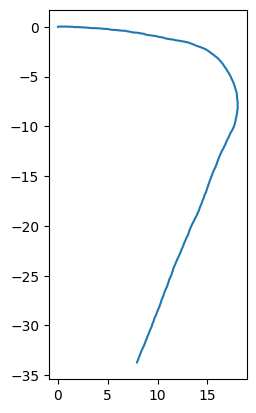

In [12]:
plt.plot(x[0,:],x[1,:])
plt.gca().set_aspect('equal')

In [13]:
def compute_slip_angles(x, u, theta, model):
    
    # extract model parameters
    l_r = model['l_r']
    l_f = model['l_f']
    Cr = model['Cr']
    Cf = model['Cf']
    Br = model['Br']
    Bf = model['Bf']
    Cm1 = model['Cm1']
    Cm2 = model['Cm2']
    Croll = model['Croll']
    Cd = model['Cd']
    m = model['m']
    Iz = model['Iz']
    
    # parameters
    if theta.shape[1] > 1:
        D_r = theta[0,0]
        D_f = theta[1,0]
    else:
        D_r = theta[0]
        D_f = theta[1]
    
    vx = x[3,0]
    vy = x[4,0]
    omega = x[5,0]
    delta = u[0,0]
    
    alpha = []
    F = [] 
    
    for i in range(x.shape[1]-1):
        vx = x[3,i]
        vy = x[4,i]
        omega = x[5,i]
        delta = u[0,i]
        if theta.shape[1] > 1:
            D_r = theta[0,i]
            D_f = theta[1,i]
        alpha_r = atan2((vy-omega*l_r),vx)
        alpha_f = atan2((vy+omega*l_f),vx) - delta
        alpha_temp = vertcat(alpha_r, alpha_f)
        alpha.append(alpha_temp)
        F_temp = vertcat(-D_r*sin(Cr*atan(Br*alpha_r)), \
                         -D_f*sin(Cf*atan(Bf*alpha_f)))
        F.append(F_temp)
        
    alpha = np.array(alpha).squeeze().transpose()
    F = np.array(F).squeeze().transpose()
    return alpha, F

## Moving Horizon Estimation

In [14]:
def constraint_dynamics(x_plus,x,u,w,theta,model):
    return x_plus - discrete_dynamcis(x,u,w,theta,model)

In [15]:
def constraint_measurement(y,x,v,model):
    return y - measurement_function(x,v,model)

In [16]:
def generate_mhe(M,model):
    eta = model['eta']
    nx = model['nx']
    ny = model['ny']
    nw = model['nx']
    nv = model['ny']
    nu = model['nu']
    n_theta = model['ntheta']
    
    # variables
    shooting = struct_symMX([entry("x_est", repeat=M+1, shape=nx),
                             entry("y_est", repeat=M, shape=ny),
                             entry("theta_est", repeat=1, shape=n_theta),
                             entry("w_est", repeat=M, shape=nw),
                             entry("v_est", repeat=M, shape=nv)])

    # parameters
    parameters = struct_symMX([entry("y_meas", repeat=M, shape=ny),
                               entry("u", repeat=M, shape=nu),
                               entry("x_prior", repeat=1, shape=nx),
                               entry("theta_prior", repeat=1, shape=n_theta)])
    
    Q = np.eye(nw + nv)
    Q_w = Q[0:nw,0:nw] / ( model['bound_w'] * model['bound_w'])
    Q_v = Q[nw:nw+nv,nw:nw+nv]
    Q_v[:-1,:-1] = Q_v[:-1,:-1] / (model['bound_vx'] * model['bound_vx'])
    Q_v[-1,-1] = Q_v[-1,-1] / (model['bound_vw'] * model['bound_vw'])
    R = Q_v
    P_2 = np.eye(nx) * model['prior_weighting']
    P_theta = np.eye(n_theta) * model['prior_weighting']
    
    objective = 0
    constraints = []
    for k in range(M):
        
        # objective
        delta_y = shooting["y_est"][k] - parameters["y_meas"][k]
        objective += pow(eta, M - k - 1) \
                        * (2 * shooting["w_est"][k][:].reshape((1,nw)) \
                           @ Q_w @ shooting["w_est"][k][:])
        objective += pow(eta, M - k - 1) \
                        * (2 * shooting["v_est"][k][:].reshape((1,nv)) \
                           @ Q_v @ shooting["v_est"][k][:])
        objective += pow(eta, M - k - 1) \
                        * (delta_y.reshape((1,ny)) @ R @ delta_y)
        
        # dynamics
        constraints.append(constraint_dynamics(shooting["x_est"][k+1], \
                                              shooting["x_est"][k], \
                                              parameters["u"][k], \
                                              shooting["w_est"][k], \
                                              shooting["theta_est"][0], model))
        
        # measurements
        constraints.append(shooting["y_est"][k] - \
                           measurement_function(shooting["x_est"][k], \
                           shooting["v_est"][k], model))
    # prior weighting
    delta_x_prior = shooting["x_est"][0] - parameters["x_prior"][0]
    objective += 2 * pow(eta, M) * delta_x_prior.reshape((1,nx)) \
                 @ P_2 @ delta_x_prior 
    
    delta_theta_prior = shooting["theta_est"][0] - parameters["theta_prior"][0]
    objective += 2 * pow(eta, M) * delta_theta_prior.reshape((1,n_theta)) \
                 @ P_theta @ delta_theta_prior
        
    nlp = {"x":shooting, "p":parameters, "f":objective, "g":vertcat(*constraints)}
    opts = {"ipopt.print_level":2, "print_time": False, 'ipopt.max_iter':3e3}
    solver = nlpsol("nlpsol", "ipopt", nlp, opts)
    
    return [solver, shooting, parameters]

In [17]:
def generate_mhe_standard(M,theta,model):
    eta = model['eta']
    nx = model['nx']
    ny = model['ny']
    nw = model['nx']
    nv = model['ny']
    nu = model['nu']
    
    # variables
    shooting = struct_symMX([entry("x_est", repeat=M+1, shape=nx),
                             entry("y_est", repeat=M, shape=ny),
                             entry("w_est", repeat=M, shape=nw),
                             entry("v_est", repeat=M, shape=nv)])

    # parameters
    parameters = struct_symMX([entry("y_meas", repeat=M, shape=ny),
                               entry("u", repeat=M, shape=nu),
                               entry("x_prior", repeat=1, shape=nx)])
    
    Q = np.eye(nw + nv)
    Q_w = Q[0:nw,0:nw] / ( model['bound_w'] * model['bound_w'])
    Q_v = Q[nw:nw+nv,nw:nw+nv]
    Q_v[:-1,:-1] = Q_v[:-1,:-1] / (model['bound_vx'] * model['bound_vx'])
    Q_v[-1,-1] = Q_v[-1,-1] / (model['bound_vw'] * model['bound_vw'])
    R = Q_v
    P_2 = np.eye(nx) * model['prior_weighting']
    
    objective = 0
    constraints = []
        
    for k in range(M):
        
        # objective
        delta_y = shooting["y_est"][k] - parameters["y_meas"][k]
        objective += pow(eta, M - k - 1) \
                        * (2 * shooting["w_est"][k][:].reshape((1,nw)) \
                           @ Q_w @ shooting["w_est"][k][:])
        objective += pow(eta, M - k - 1) \
                        * (2 * shooting["v_est"][k][:].reshape((1,nv)) \
                           @ Q_v @ shooting["v_est"][k][:])
        objective += pow(eta, M - k - 1) \
                        * (delta_y.reshape((1,ny)) @ R @ delta_y)
        
        # dynamics
        constraints.append(constraint_dynamics(shooting["x_est"][k+1], \
                                              shooting["x_est"][k], \
                                              parameters["u"][k], \
                                              shooting["w_est"][k], \
                                              theta, model))
        
        # measurements
        constraints.append(shooting["y_est"][k] - \
                           measurement_function(shooting["x_est"][k], \
                           shooting["v_est"][k], model))
    # prior weighting
    delta_x_prior = shooting["x_est"][0] - parameters["x_prior"][0]
    objective += 2 * pow(eta, M) * delta_x_prior.reshape((1,nx)) \
                 @ P_2 @ delta_x_prior 
        
    nlp = {"x":shooting, "p":parameters, "f":objective, "g":vertcat(*constraints)}
    opts = {"ipopt.print_level":2, "print_time": False, 'ipopt.max_iter':3e3}
    solver = nlpsol("nlpsol", "ipopt", nlp, opts)
    
    return [solver, shooting, parameters]

In [18]:
#estimation
nx = model['nx']
ny = model['ny']
nw = model['nw']
nv = model['nv']
ntheta = model['ntheta']


x_est_0 = np.array(x0)
x_est_0[3] = 3.8
theta_est_0 = 2 * np.array(theta)

# MHE with theta_0 for prior
x_mhe_theta_0 = np.zeros((nx, nsim))
x_mhe_theta_0[:,0] = x_est_0
theta_mhe_theta_0 = np.zeros((ntheta, nsim))
theta_mhe_theta_0[:,[0]] = theta_est_0

# MHE with theta_t-M as prior 
x_mhe_theta_M = np.zeros((nx, nsim))
x_mhe_theta_M[:,0] = x_est_0
theta_mhe_theta_M = np.zeros((ntheta, nsim))
theta_mhe_theta_M[:,[0]] = theta_est_0

# MHE with no prior
x_mhe_no_prior = np.zeros((nx, nsim))
x_mhe_no_prior[:,0] = x_est_0
theta_mhe_no_prior = np.zeros((ntheta,nsim))

# Standard MHE
x_mhe_standard = np.zeros((nx, nsim))
x_mhe_standard[:,0] = x_est_0

# initialization

initial_states_theta_0 = np.hstack((x_est_0.reshape((nx,1)), \
                discrete_dynamcis(x_est_0, u[0], np.zeros(model['nw']), theta_est_0, model)))
initial_states_theta_M = initial_states_theta_0
initial_states_no_prior = initial_states_theta_0
initial_states_standard = initial_states_theta_0

bool_start_with_fie = 1

In [19]:
def generate_lbx_ubx(shooting, model):
    lbx = shooting(-np.inf)
    ubx = shooting(np.inf)

    lbx["w_est"] = -model["bound_w"] * np.ones(model["nw"])
    lbx["v_est"] = -np.array([model["bound_vx"],model["bound_vx"],model["bound_vw"]])
    ubx["w_est"] = model["bound_w"] * np.ones(model["nw"])
    ubx["v_est"] = np.array([model["bound_vx"],model["bound_vx"],model["bound_vw"]])
    
    return lbx, ubx

In [20]:
M = 20

## generate MHE / FIE
mhe_struct = []
parameter_struct = []
shooting_struct = []
lbx_struct = []
ubx_struct = []
for k in range(1,M+1): # M + 1 if only MHE, nsim + 1 if FIE
    solver, shooting, parameters = generate_mhe(k,model)
    mhe_struct.append(solver)
    parameter_struct.append(parameters)
    shooting_struct.append(shooting)
    
    lbx, ubx = generate_lbx_ubx(shooting, model)
    
    lbx_struct.append(lbx)
    ubx_struct.append(ubx)
    
## generate standard MHE / FIE
mhe_struct_standard = []
parameter_struct_standard = []
shooting_struct_standard = []
lbx_struct_standard = []
ubx_struct_standard = []
for k in range(1,M+1): # M + 1 if only MHE, nsim + 1 if FIE
    solver, shooting, parameters = generate_mhe_standard(k,theta_est_0,model)
    mhe_struct_standard.append(solver)
    parameter_struct_standard.append(parameters)
    shooting_struct_standard.append(shooting)
    
    lbx, ubx = generate_lbx_ubx(shooting, model)
    
    lbx_struct_standard.append(lbx)
    ubx_struct_standard.append(ubx)

In [21]:
#find initialization (warm-start) which satisfies dynamic constraints
def initialize_x(initial_states, action, theta, model):
    n_w = model['nw']
    x_plus = discrete_dynamcis(initial_states[:,-1], action, np.zeros(n_w), theta, model)
    initial_states = horzcat(initial_states,x_plus)
    return initial_states

In [22]:
for k in range(1,nsim):
    if k < M:
        if bool_start_with_fie: # initial phase with FIE
            ## MHE with prior on theta(0) and theta(k-M)
            current_parameters = parameter_struct[k-1](0)
            current_parameters["y_meas",lambda x: horzcat(*x)] = y[:, 0:k]
            current_parameters["u",lambda x: horzcat(*x)] = u[:, 0:k]
            current_parameters["x_prior",lambda x: horzcat(*x)] = x_mhe_theta_0[:,0]
            current_parameters["theta_prior",lambda x: horzcat(*x)] = theta_mhe_theta_0[:,0]
            
            # initialization
            initial_value = shooting_struct[k-1](0)
            initial_value["x_est",lambda x: horzcat(*x)] = initial_states_theta_0
            initial_value["y_est",lambda x: horzcat(*x)] = y[:, 0:k]
            initial_value["theta_est",lambda x: horzcat(*x)] = theta_mhe_theta_0[:,k-1]
            initial_value["w_est",lambda x: horzcat(*x)] = np.zeros((nw,k))
            initial_value["v_est",lambda x: horzcat(*x)] = np.zeros((nv,k))
            
            res = mhe_struct[k-1](x0=initial_value, p=current_parameters, lbx=lbx_struct[k-1], \
                                  ubx=ubx_struct[k-1], lbg=0, ubg=0)
            if not mhe_struct[k-1].stats()["success"]:
                print('FIE not solved successfully',k)
                print(mhe_struct[k-1].stats()["return_status"])
            solution = shooting_struct[k-1](res['x'])
            
            # initialization for next run
            x_est_sol = np.array(solution['x_est']).squeeze().transpose()
            initial_states_theta_0 = initialize_x(x_est_sol, u[:,k], theta_mhe_theta_0[:,k-1], model)
            initial_states_theta_M = initial_states_theta_0
            
            # MHE with prior theta(0)
            x_mhe_theta_0[:,[k]] = solution['x_est'][k]
            theta_mhe_theta_0[:,[k]] = solution['theta_est'][0]
        
            # MHE with prior theta(k-M)
            x_mhe_theta_M[:,k] = x_mhe_theta_0[:,k]
            theta_mhe_theta_M[:,k] = theta_mhe_theta_0[:,k]
            
            ## standard MHE
            current_parameters = parameter_struct_standard[k-1](0)
            current_parameters["y_meas",lambda x: horzcat(*x)] = y[:, 0:k]
            current_parameters["u",lambda x: horzcat(*x)] = u[:, 0:k]
            current_parameters["x_prior",lambda x: horzcat(*x)] = x_mhe_standard[:,0]
            
            # initialization
            initial_value = shooting_struct_standard[k-1](0)
            initial_value["x_est",lambda x: horzcat(*x)] = initial_states_standard
            initial_value["y_est",lambda x: horzcat(*x)] = y[:, 0:k]
            initial_value["w_est",lambda x: horzcat(*x)] = np.zeros((nw,k))
            initial_value["v_est",lambda x: horzcat(*x)] = np.zeros((nv,k))
            
            res = mhe_struct_standard[k-1](x0=initial_value, p=current_parameters, lbx=lbx_struct_standard[k-1], \
                                  ubx=ubx_struct_standard[k-1], lbg=0, ubg=0)
            if not mhe_struct_standard[k-1].stats()["success"]:
                print('FIE standard not solved successfully', k)
                print(mhe_struct_standard[k-1].stats()["return_status"])
            solution = shooting_struct_standard[k-1](res['x'])
            x_mhe_standard[:,[k]] = solution['x_est'][k]
            
            # initialization for next run
            x_est_sol = np.array(solution['x_est']).squeeze().transpose()
            initial_states_standard = initialize_x(x_est_sol, u[:,k], theta_est_0, model)
            
        
        else: # initialize with true states and parameters
            # MHE with prior theta(0)
            x_mhe_theta_0[:,k] = x[:,k]
            theta_mhe_theta_0[:,k] = theta
        
            # MHE with prior theta(k-M)
            x_mhe_theta_M[:,k] = x_mhe_theta_0[:,k]
            theta_mhe_theta_M[:,k] = theta_mhe_theta_0[:,k]
            
    else:
        current_parameters = parameter_struct[M-1](0)
        current_parameters["y_meas",lambda x: horzcat(*x)] = y[:, k-M:k]
        current_parameters["u",lambda x: horzcat(*x)] = u[:, k-M:k]
        
        ## MHE with prior theta(0)
        # initialization
        initial_value = shooting_struct[M-1](0)
        initial_value["x_est",lambda x: horzcat(*x)] = initial_states_theta_0
        initial_value["y_est",lambda x: horzcat(*x)] = y[:, k-M:k]
        initial_value["theta_est",lambda x: horzcat(*x)] = theta_mhe_theta_0[:,k-1]
        initial_value["w_est",lambda x: horzcat(*x)] = np.zeros((nw,M))
        initial_value["v_est",lambda x: horzcat(*x)] = np.zeros((nv,M))
        
        # run MHE with prior theta(0)
        current_parameters["x_prior",lambda x: horzcat(*x)] = x_mhe_theta_0[:,k-M]
        current_parameters["theta_prior",lambda x: horzcat(*x)] = theta_mhe_theta_0[:,0]
        res = mhe_struct[M-1](x0=initial_value, p=current_parameters, lbx=lbx_struct[M-1], \
                                  ubx=ubx_struct[M-1], lbg=0, ubg=0)
        if not mhe_struct[M-1].stats()["success"]:
            print('MHE theta_0 not solved successfully', k)
            print(mhe_struct[M-1].stats()["return_status"])
        solution = shooting_struct[M-1](res['x'])
        x_mhe_theta_0[:,[k]] = solution['x_est'][M]
        theta_mhe_theta_0[:,[k]] = solution['theta_est'][0]
        
        # initialization for next run
        x_est_sol = np.array(solution['x_est']).squeeze().transpose()
        initial_states_theta_0 = initialize_x(x_est_sol[:,1:], u[:,k], theta_mhe_theta_0[:,k-1], model)
        
        ## MHE with prior theta(k-M)
        # initialization
        initial_value = shooting_struct[M-1](0)
        initial_value["x_est",lambda x: horzcat(*x)] = initial_states_theta_M
        initial_value["y_est",lambda x: horzcat(*x)] = y[:, k-M:k]
        initial_value["theta_est",lambda x: horzcat(*x)] = theta_mhe_theta_M[:,k-1]
        initial_value["w_est",lambda x: horzcat(*x)] = np.zeros((nw,M))
        initial_value["v_est",lambda x: horzcat(*x)] = np.zeros((nv,M))
        
        # run MHE with prior theta(k-M)
        current_parameters["x_prior",lambda x: horzcat(*x)] = x_mhe_theta_M[:,k-M]
        current_parameters["theta_prior",lambda x: horzcat(*x)] = theta_mhe_theta_M[:,k-M]
        res = mhe_struct[M-1](x0=initial_value, p=current_parameters, lbx=lbx_struct[M-1], \
                                  ubx=ubx_struct[M-1], lbg=0, ubg=0)
        if not mhe_struct[M-1].stats()["success"]:
            print('MHE theta_M not solved successfully', k)
            print(mhe_struct[M-1].stats()["return_status"])
        solution = shooting_struct[M-1](res['x'])
        x_mhe_theta_M[:,[k]] = solution['x_est'][M]
        theta_mhe_theta_M[:,[k]] = solution['theta_est'][0]
        
        # initialization for next run
        x_est_sol = np.array(solution['x_est']).squeeze().transpose()
        initial_states_theta_M = initialize_x(x_est_sol[:,1:], u[:,k], theta_mhe_theta_M[:,k-1], model)
        
        ## standard MHE
        current_parameters = parameter_struct_standard[M-1](0)
        current_parameters["y_meas",lambda x: horzcat(*x)] = y[:, k-M:k]
        current_parameters["u",lambda x: horzcat(*x)] = u[:, k-M:k]
        current_parameters["x_prior",lambda x: horzcat(*x)] = x_mhe_standard[:,k-M]
        
        # initialization
        initial_value = shooting_struct_standard[M-1](0)
        initial_value["x_est",lambda x: horzcat(*x)] = initial_states_standard
        initial_value["y_est",lambda x: horzcat(*x)] = y[:, k-M:k]
        initial_value["w_est",lambda x: horzcat(*x)] = np.zeros((nw,M))
        initial_value["v_est",lambda x: horzcat(*x)] = np.zeros((nv,M))
        
        # run standard MHE
        res = mhe_struct_standard[M-1](x0=initial_value, p=current_parameters, lbx=lbx_struct_standard[M-1], \
                                  ubx=ubx_struct_standard[M-1], lbg=0, ubg=0)
        if not mhe_struct_standard[M-1].stats()["success"]:
            print('MHE standard not solved successfully', k)
            print(mhe_struct_standard[M-1].stats()["return_status"])
        solution = shooting_struct_standard[M-1](res['x'])
        x_mhe_standard[:,[k]] = solution['x_est'][M]
        
        # initialization for next run
        x_est_sol = np.array(solution['x_est']).squeeze().transpose()
        initial_states_standard = initialize_x(x_est_sol[:,1:], u[:,k], theta_est_0, model)
        
        


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



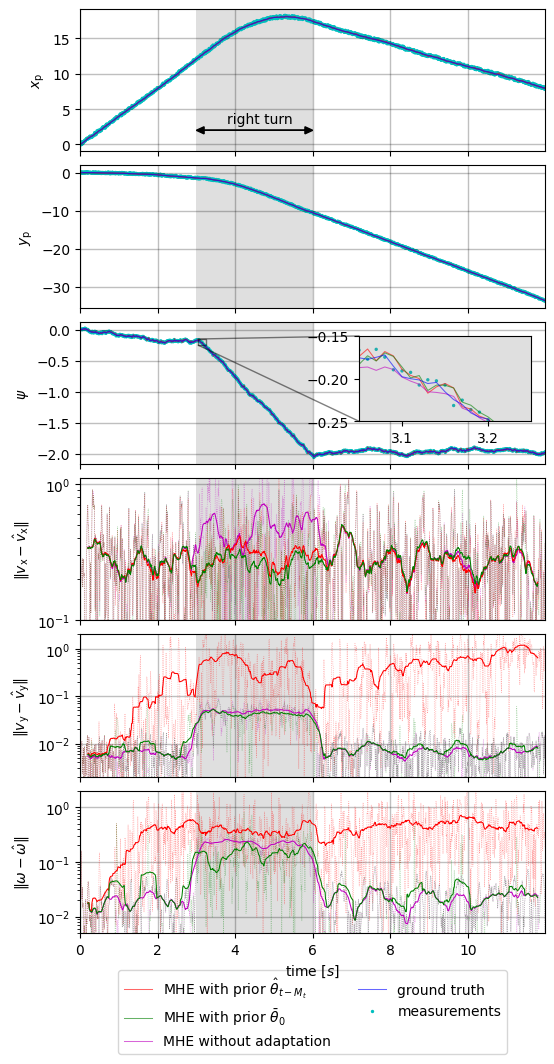

In [23]:
plot_end = (nsim -1) * model['Ts']
t_start = k_start * model['Ts']
t_end = k_end * model['Ts']
N_smooth = 40

# plot state estimates
colors = ['b','g','r','c','m','y']
labels = ['ground truth', r'MHE with prior $\bar{\theta}_0$', r'MHE with prior $\hat{\theta}_{t-M_t}$', \
          'measurements', r'MHE without adaptation', 'MHE without prior weighting']
ylabels = [r'$x_{\mathrm{p}}$', r'$y_{\mathrm{p}}$', r'$\psi$', r'$\|v_{\mathrm{x}} - \hat{v}_{\mathrm{x}}\|$', \
           r'$\|v_{\mathrm{y}} - \hat{v}_{\mathrm{y}}\|$', r'$\|\omega - \hat{\omega}\|$']

## print system evolution
f, ax = plt.subplots(6,1, figsize=(6,12))
f.subplots_adjust(hspace=0.1)
plt.rc('text.latex', preamble=r'\usepackage{times}')

# plot measured states
for i in range(3):
    ax[i].set_ylabel(ylabels[i])
    ax[i].plot([float(x)*model['Ts'] for x in range(nsim)],x_mhe_theta_M[i,:], color=colors[2], \
               label=labels[2],alpha=0.6, linewidth=0.75)
    ax[i].plot([float(x)*model['Ts'] for x in range(nsim)],x_mhe_theta_0[i,:], color=colors[1], \
               label=labels[1],alpha=0.6, linewidth=0.75)
    ax[i].plot([float(x)*model['Ts'] for x in range(nsim)],x_mhe_standard[i,:], color=colors[4], \
               label=labels[4],alpha=0.6, linewidth=0.75)
    ax[i].plot([float(x)*model['Ts'] for x in range(nsim+1)],x[i,:], color=colors[0], \
               label=labels[0],alpha=0.6, linewidth=0.75)
    ax[i].set_xlim([0,plot_end])
    ax[i].xaxis.set_ticklabels([])
    ax[i].grid(color='k', linestyle='-', linewidth=1, alpha=0.25)
    ax[i].axvspan(t_start,t_end, facecolor='gray', alpha=0.25)
    
ax[0].arrow(3.2, 2, 2.8, 0, color='k', head_length = 0.2, head_width = 1, 
          length_includes_head = True)
ax[0].arrow(3.2, 2, -0.2, 0, color='k', head_length = 0.2, head_width = 1, 
          length_includes_head = True)
ax[0].text(3.8,3,r'right turn')
    
# plot estimation error non-measured states
for i in range(3,x.shape[0]):
    ax[i].set_ylabel(ylabels[i])
    e_theta_M = abs(x_mhe_theta_M[i,:] - x[i,:nsim])
    e_theta_M_smooth = np.convolve(e_theta_M, np.ones(N_smooth)/N_smooth, mode='valid')
    e_theta_0 = abs(x_mhe_theta_0[i,:] - x[i,:nsim])
    e_theta_0_smooth = np.convolve(e_theta_0, np.ones(N_smooth)/N_smooth, mode='valid')
    e_standard = abs(x_mhe_standard[i,:] - x[i,:nsim])
    e_standard_smooth = np.convolve(e_standard, np.ones(N_smooth)/N_smooth, mode='valid')
    ax[i].plot([float(x)*model['Ts'] for x in range(nsim)],e_standard, color=colors[4], \
               alpha=0.4, linestyle=':', linewidth=0.5)
    ax[i].plot([float(x)*model['Ts'] for x in range(nsim)],e_theta_M, color=colors[2], \
               alpha=0.4, linestyle=':', linewidth=0.5)
    ax[i].plot([float(x)*model['Ts'] for x in range(nsim)],e_theta_0, color=colors[1], \
               alpha=0.4, linestyle=':', linewidth=0.5)
    ax[i].plot([float(x)*model['Ts'] for x in range(int(N_smooth/2), nsim-int(N_smooth/2)+1)],e_standard_smooth, color=colors[4],label=labels[1], \
               alpha=1, linestyle='-', linewidth=0.75)
    ax[i].plot([float(x)*model['Ts'] for x in range(int(N_smooth/2), nsim-int(N_smooth/2)+1)],e_theta_M_smooth, color=colors[2],label=labels[2], \
               alpha=1, linestyle='-', linewidth=0.75)
    ax[i].plot([float(x)*model['Ts'] for x in range(int(N_smooth/2), nsim-int(N_smooth/2)+1)],e_theta_0_smooth, color=colors[1],label=labels[1], \
               alpha=1, linestyle='-', linewidth=0.75)
    ax[i].set_xlim([0,plot_end])
    ax[i].set_yscale('log')
    if i < 5:
        ax[i].xaxis.set_ticklabels([])
    ax[i].grid(color='k', linestyle='-', linewidth=1, alpha=0.25)
    ax[i].axvspan(t_start,t_end, facecolor='gray', alpha=0.25)
    
ax[3].set_ylim(bottom=0.1,top=1.1)
ax[4].set_ylim(bottom=0.002,top=2)
ax[5].set_ylim(bottom=0.005,top=2)
ax[5].set_xlabel(r'time [$s$]')

# plot measurements
for i in range(y.shape[0]):
    ax[i].scatter([float(x)*model['Ts'] for x in range(nsim)],y[i,:], color=colors[3],sizes=2*np.ones(nsim),label=labels[3])
    
# plot legend
ax[1].legend(loc='lower center', bbox_to_anchor=(0.5, -5.3), ncol=2)

# inset axis
axins = ax[2].inset_axes([0.6, 0.3, 0.37, 0.6])
axins.plot([float(x)*model['Ts'] for x in range(nsim)],x_mhe_theta_M[2,:], color=colors[2], \
               label=labels[2],alpha=0.6, linewidth=0.75)
axins.plot([float(x)*model['Ts'] for x in range(nsim)],x_mhe_theta_0[2,:], color=colors[1], \
               label=labels[1],alpha=0.6, linewidth=0.75)
axins.plot([float(x)*model['Ts'] for x in range(nsim)],x_mhe_standard[i,:], color=colors[4], \
               label=labels[4],alpha=0.6, linewidth=0.75)
axins.plot([float(x)*model['Ts'] for x in range(nsim+1)],x[2,:], color=colors[0], \
               label=labels[0],alpha=0.6, linewidth=0.75)
#axins.grid(color='k', linestyle='-', linewidth=1, alpha=0.25)
axins.scatter([float(x)*model['Ts'] for x in range(nsim)],y[2,:], color=colors[3],sizes=2*np.ones(nsim),label=labels[3])
axins.set_xlim(3.05, 3.25)
axins.set_ylim(-0.25, -0.15)
axins.axvspan(t_start,t_end, facecolor='gray', alpha=0.25)

ax[2].indicate_inset_zoom(axins, edgecolor="black", alpha=0.5)

f.savefig(os.getcwd() + '/plot_car_states.pdf', bbox_inches='tight', pad_inches=0.04)

In [24]:
# Compute slip angles and forces
alpha, F = compute_slip_angles(x, u, theta, model)
alpha_theta_M, F_theta_M = compute_slip_angles(x_mhe_theta_M, u, theta_mhe_theta_M, model)
alpha_theta_0, F_theta_0 = compute_slip_angles(x_mhe_theta_0, u, theta_mhe_theta_0, model)
alpha_standard, F_standard = compute_slip_angles(x_mhe_standard, u, theta_est_0 *np.ones(nsim), model)

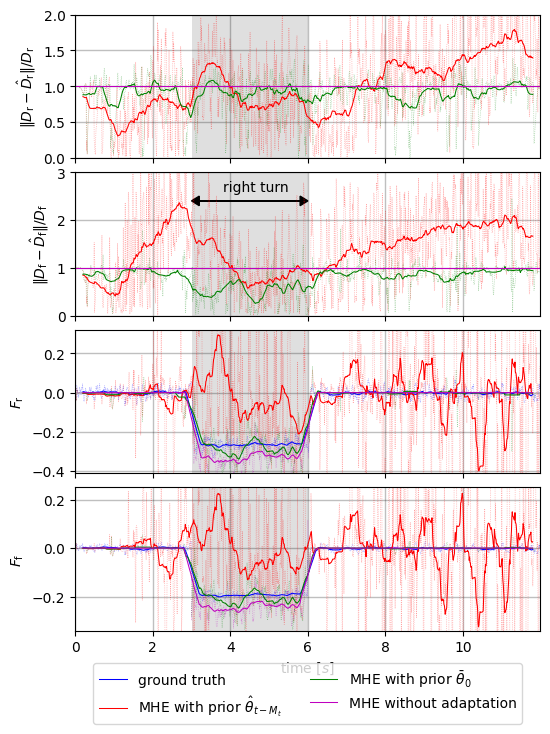

In [25]:
# plot parameter estimates
f, ax = plt.subplots(4,1, figsize=(6,8))
f.subplots_adjust(hspace=0.1)
plt.rc('text.latex', preamble=r'\usepackage{times}')

y_labels = [r'$\|D_{\mathrm{r}} - \hat{D}_{\mathrm{r}}\|/D_{\mathrm{r}}$', \
            r'$\|D_{\mathrm{f}} - \hat{D}_{\mathrm{f}}\|/D_{\mathrm{f}}$', \
            r'$F_{\mathrm{r}}$', r'$F_{\mathrm{f}}$']

# plot parameters
for i in range(theta.shape[0]):
    e_theta_M = abs(theta_mhe_theta_M[i,:] \
               - np.array(theta[i]).squeeze() * np.ones(nsim)) / np.array(theta[i]).squeeze()
    e_theta_M_smooth = np.convolve(e_theta_M, np.ones(N_smooth)/N_smooth, mode='valid')
    e_theta_0 = abs(theta_mhe_theta_0[i,:] \
               - np.array(theta[i]).squeeze() * np.ones(nsim)) / np.array(theta[i]).squeeze()
    e_theta_0_smooth = np.convolve(e_theta_0, np.ones(N_smooth)/N_smooth, mode='valid')
    ax[i].set_ylabel(y_labels[i])
    ax[i].set_xlim([0,plot_end])
    ax[i].plot([float(x)*model['Ts'] for x in range(nsim)],e_theta_M, color=colors[2], \
               alpha=0.4, linestyle=':', linewidth=0.5)
    ax[i].plot([float(x)*model['Ts'] for x in range(nsim)],e_theta_0, color=colors[1], \
               alpha=0.4, linestyle=':', linewidth=0.5)
    ax[i].plot([float(x)*model['Ts'] for x in range(int(N_smooth/2), nsim-int(N_smooth/2)+1)],e_theta_M_smooth, color=colors[2],label=labels[2], \
               alpha=1, linestyle='-', linewidth=0.75)
    ax[i].plot([float(x)*model['Ts'] for x in range(int(N_smooth/2), nsim-int(N_smooth/2)+1)],e_theta_0_smooth, color=colors[1],label=labels[1], \
               alpha=1, linestyle='-', linewidth=0.75)
    ax[i].plot(range(nsim),abs(theta_est_0[i] - theta[i]) * np.ones(nsim) / np.array(theta[i]).squeeze(), \
               color=colors[4],label=labels[4], alpha=1, linestyle='-', linewidth=0.75)
    ax[i].xaxis.set_ticklabels([])
    ax[i].grid(color='k', linestyle='-', linewidth=1, alpha=0.25)
    ax[i].axvspan(t_start,t_end, facecolor='gray', alpha=0.25)
    ax[i].set_ylim(bottom=0)

ax[0].set_ylim(top=2)
ax[1].set_ylim(top=3)

ax[1].arrow(3.2, 2.4, 2.8, 0, color='k', head_length = 0.2, head_width = 0.2, 
          length_includes_head = True)
ax[1].arrow(3.2, 2.4, -0.2, 0, color='k', head_length = 0.2, head_width = 0.2, 
          length_includes_head = True)
ax[1].text(3.8,2.6,r'right turn')

for i in range(F.shape[0]):
    F_theta_M_smooth = np.convolve(F_theta_M[i,:], np.ones(N_smooth)/N_smooth, mode='valid')
    F_theta_0_smooth = np.convolve(F_theta_0[i,:], np.ones(N_smooth)/N_smooth, mode='valid')
    F_standard_smooth = np.convolve(F_standard[i,:], np.ones(N_smooth)/N_smooth, mode='valid')
    F_smooth = np.convolve(F[i,:], np.ones(N_smooth)/N_smooth, mode='valid')
    
    j = i + theta.shape[0]
    ax[j].set_ylabel(y_labels[j])
    ax[j].set_xlim([0,plot_end])
    ax[j].plot([float(x)*model['Ts'] for x in range(nsim-1)],F_theta_M[i,:], color=colors[2], \
               alpha=0.4, linestyle=':', linewidth=0.5)
    ax[j].plot([float(x)*model['Ts'] for x in range(nsim-1)],F_theta_0[i,:], color=colors[1], \
               alpha=0.4, linestyle=':', linewidth=0.5)
    ax[j].plot([float(x)*model['Ts'] for x in range(nsim-1)],F_standard[i,:], color=colors[4], \
               alpha=0.4, linestyle=':', linewidth=0.5)
    ax[j].plot([float(x)*model['Ts'] for x in range(nsim)], F[i,:], color=colors[0], \
               alpha=0.4, linestyle=':', linewidth=0.5)
    ax[j].plot([float(x)*model['Ts'] for x in range(int(N_smooth/2), nsim-int(N_smooth/2)+1)],F_smooth, color=colors[0],label=labels[0], \
               alpha=1, linestyle='-', linewidth=0.75)
    ax[j].plot([float(x)*model['Ts'] for x in range(int(N_smooth/2), nsim-int(N_smooth/2))],F_theta_M_smooth, color=colors[2],label=labels[2], \
               alpha=1, linestyle='-', linewidth=0.75)
    ax[j].plot([float(x)*model['Ts'] for x in range(int(N_smooth/2), nsim-int(N_smooth/2))],F_theta_0_smooth, color=colors[1],label=labels[1], \
               alpha=1, linestyle='-', linewidth=0.75)
    ax[j].plot([float(x)*model['Ts'] for x in range(int(N_smooth/2), nsim-int(N_smooth/2))],F_standard_smooth, color=colors[4],label=labels[4], \
               alpha=1, linestyle='-', linewidth=0.75)
    if i < 1:
        ax[j].xaxis.set_ticklabels([])
    ax[j].grid(color='k', linestyle='-', linewidth=1, alpha=0.25)
    ax[j].axvspan(t_start,t_end, facecolor='gray', alpha=0.25)
    
ax[2].set_ylim(-0.41,0.32)
ax[3].set_ylim(-0.34,0.25)

ax[-1].set_xlabel(r'time [$s$]')

# plot legend
ax[-1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.7), ncol=2)

f.savefig(os.getcwd() + '/plot_car_parameters_forces.pdf', bbox_inches='tight', pad_inches=0.04)